In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Causal_Inference_Model/

/content/drive/MyDrive/Causal_Inference_Model


In [5]:
import sys, os

In [6]:
sys.path.append(os.path.abspath('scripts/'))

In [8]:
!pip install causalnex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 5.2 MB/s 
     |████████████████████████████████| 27.4 MB 78.6 MB/s 
     |████████████████████████████████| 1.9 MB 56.0 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 22.3 MB 41.8 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 115 kB 64.9 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68719 sha256=055447acc1628368407a43a977a023d8e1932af155f3151f99a7fc52b1c842f8
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: scikit-learn
    Found existing in

Import Libraries

In [11]:
import warnings
import pandas as pd
from causalnex.structure import StructureModel
from causal_pipeline import EDAPipeline
from causal_helper import CausalHelper
warnings.filterwarnings("ignore")

In [13]:
preprocessed_trip_df = pd.read_csv("data/processed_trip.csv")
preprocessed_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534369 entries, 0 to 534368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        534369 non-null  int64  
 1   Trip ID           534369 non-null  int64  
 2   Trip Origin       534369 non-null  object 
 3   Trip Destination  534369 non-null  object 
 4   Trip Start Time   534369 non-null  object 
 5   Trip End Time     534368 non-null  object 
 6   is_weekend        534369 non-null  int64  
 7   is_holiday        534369 non-null  int64  
 8   distance          534369 non-null  float64
 9   speed             534369 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 40.8+ MB


In [14]:
#Load the second data
df_driver = pd.read_csv("data/driver_locations_during_request.csv")
df_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1557740 non-null  int64  
 1   order_id       1557740 non-null  int64  
 2   driver_id      1557740 non-null  int64  
 3   driver_action  1557740 non-null  object 
 4   lat            1557740 non-null  float64
 5   lng            1557740 non-null  float64
 6   created_at     0 non-null        float64
 7   updated_at     0 non-null        float64
dtypes: float64(4), int64(3), object(1)
memory usage: 95.1+ MB


#### Merge the two Datasets

In [15]:
preprocessed_trip_df['driver_distance'] = preprocessed_trip_df['distance'].apply(lambda x: -1)
preprocessed_trip_df['driver_lat'] = preprocessed_trip_df['distance'].apply(lambda x: 0.0)
preprocessed_trip_df['driver_lng'] = preprocessed_trip_df['distance'].apply(lambda x: 0.0)

In [16]:
causalhelper = CausalHelper()

In [17]:
driver_lat,driver_lng = causalhelper.combine_get_driver_locations(preprocessed_trip_df, df_driver)

In [18]:
preprocessed_trip_df['driver_lat'] = driver_lat
preprocessed_trip_df['driver_lng'] = driver_lng

In [20]:
driver_lat_coordinates = preprocessed_trip_df['driver_lat'].tolist()
driver_lng_coordinates = preprocessed_trip_df['driver_lng'].tolist()
ending_coordinates = []
for i in range(len(driver_lat_coordinates)):
    ending_coordinates.append(f'{driver_lat_coordinates[i]},{driver_lng_coordinates[i]}')

In [21]:
start_coordinates = preprocessed_trip_df['Trip Origin'].tolist()

#### Calculate distance based on coordinates of driver

In [24]:
causal_pipeline = EDAPipeline()

In [25]:
preprocessed_trip_df['driver_distance'] = causal_pipeline.calculate_distances(start_coordinates, ending_coordinates)

Drop all the trips with -1 driver distance which means those orders were not in the 2nd dataset

In [26]:
preprocessed_trip_df_with_drivers = preprocessed_trip_df[preprocessed_trip_df['driver_distance']!=-1]
preprocessed_trip_df_with_drivers.shape

(26436, 13)

#### Compute unfulfilled orders

In [27]:
preprocessed_trip_df_with_drivers['is_fulfilled'] = preprocessed_trip_df_with_drivers['driver_distance'].apply(
    lambda x: 1 if x !=-2 else 0)

In [28]:
preprocessed_trip_df_with_drivers[preprocessed_trip_df_with_drivers['is_fulfilled']==0].shape

(609, 14)

#### Drop Unwanted columns

In [29]:
preprocessed_trip_df_with_drivers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26436 entries, 4 to 53812
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        26436 non-null  int64  
 1   Trip ID           26436 non-null  int64  
 2   Trip Origin       26436 non-null  object 
 3   Trip Destination  26436 non-null  object 
 4   Trip Start Time   26436 non-null  object 
 5   Trip End Time     26436 non-null  object 
 6   is_weekend        26436 non-null  int64  
 7   is_holiday        26436 non-null  int64  
 8   distance          26436 non-null  float64
 9   speed             26436 non-null  float64
 10  driver_distance   26436 non-null  float64
 11  driver_lat        26436 non-null  float64
 12  driver_lng        26436 non-null  float64
 13  is_fulfilled      26436 non-null  int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 3.0+ MB


#### Store data

In [30]:
preprocessed_trip_df_with_drivers.to_csv("data/preprocessed_drivers.csv")

In [31]:
cols = ['Trip ID','Unnamed: 0', 'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time', 'driver_lat', 'driver_lng']
preprocessed_trip_df_with_drivers = preprocessed_trip_df_with_drivers.drop(columns=cols)

In [32]:
preprocessed_trip_df_with_drivers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26436 entries, 4 to 53812
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_weekend       26436 non-null  int64  
 1   is_holiday       26436 non-null  int64  
 2   distance         26436 non-null  float64
 3   speed            26436 non-null  float64
 4   driver_distance  26436 non-null  float64
 5   is_fulfilled     26436 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 1.4 MB


### Create Structural Model

In [33]:
smodel = StructureModel()

Create Edges
Transform and encode

In [34]:
import numpy as np

struct_data = preprocessed_trip_df_with_drivers.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

[]


In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

### Scale and normalize numerical data

In [36]:
from sklearn import preprocessing

x = struct_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

#### Apply the NOTEARS algorithm to learn the structure.

In [37]:
from causalnex.structure.notears import from_pandas

sm = from_pandas(df)

#### Visualize

In [42]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
!sudo apt-get install python-dev graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
python-dev is already the newest version (2.7.15~rc1-1).
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 27 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.3

In [45]:
!sudo pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pygraphviz-1.7.zip (118 kB)
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp37-cp37m-linux_x86_64.whl size=165753 sha256=aef14fb227891baa97142652df53ab96cbf14c3d1bdc2148550523045f337128
  Stored in directory: /root/.cache/pip/wheels/8c/bc/0c/ac35392b72556e75107ff610cb31b313e8471918a6d280e34c
Successfully built pygraphviz


In [46]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE


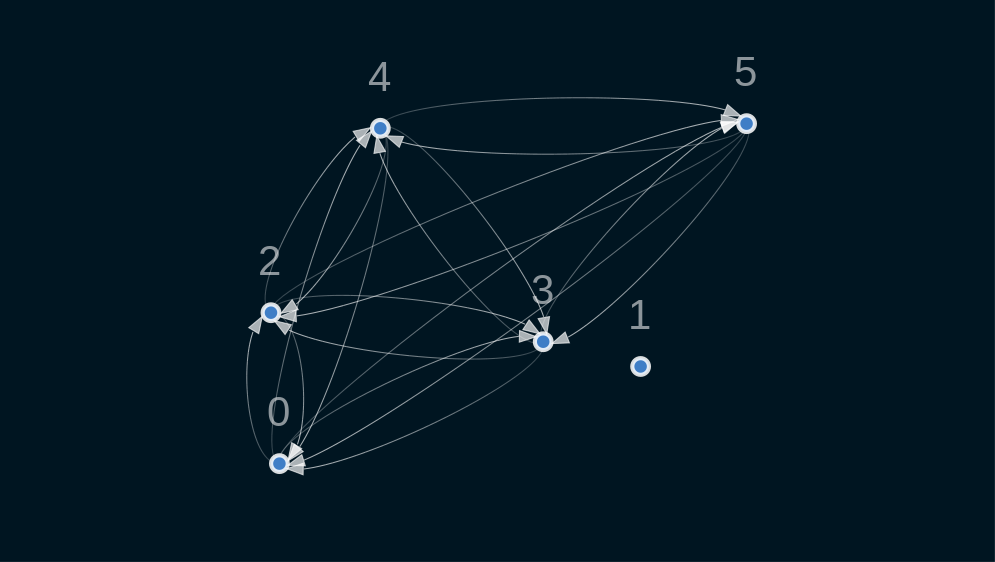

In [47]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

The reason why we have not a fully connected graph here is we haven’t applied thresholding to the weaker edges. Thresholding can be applied either by specifying the value for the parameter w_threshold in from_pandas, or we can remove the edges by calling the structure model function, remove_edges_below_threshold.

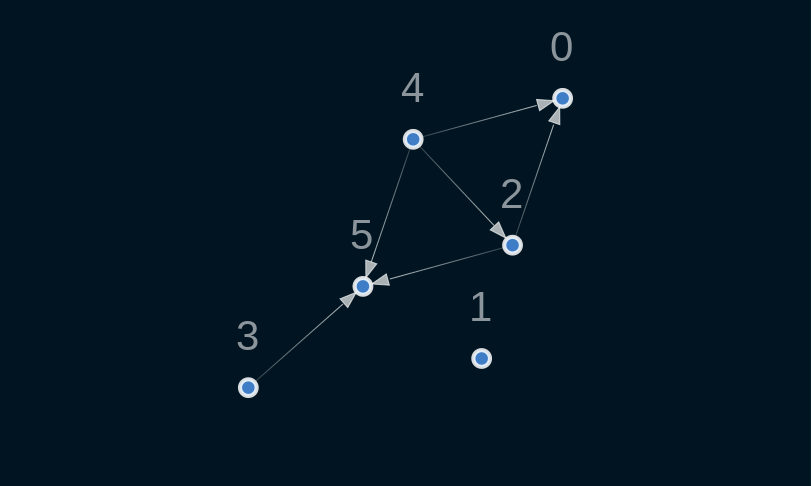

In [48]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))



Normalized column names
0 is_weekend
1 is_holiday

2 distance
3 speed
4 driver_distance
5 is_fulfilled

{'is_weekend': 0, 'is_holiday': 1, 'distance': 2, 'speed': 3, 'driver_distance': 4, 'is_fulfilled': 5}

    Correct relationships
    distance ---> is_fulfilled
    distance ---> is_fulfilled
    driver_distance ---> is_fulfilled

    Incorrect relationships
    distance ---> is_weekend
    driver_distance ---> is_weeken

Lets re-run structure learning with additional constraints to avoid incorrect relationships
Rename cols

In [49]:
df = df.rename(columns={0: "is_weekend", 1: "is_holiday", 2: "distance", 3: "speed",4: "driver_distance", 5: "is_fulfilled"}, errors="raise")

In [50]:
df

,is_weekend,is_holiday,distance,speed,driver_distance,is_fulfilled
0,0.0,0.0,0.030832,0.018849,0.004094,1.0
1,0.0,0.0,0.011927,0.000770,0.006017,1.0
2,0.0,0.0,0.007388,0.000266,0.007518,1.0
3,0.0,0.0,0.008225,0.000519,0.004859,1.0
4,0.0,0.0,0.028036,0.001399,0.003340,1.0
...,...,...,...,...,...,...
26431,0.0,0.0,0.003773,0.000197,0.005521,1.0
26432,1.0,0.0,0.005256,0.001202,0.007197,1.0
26433,1.0,0.0,0.039313,0.001822,0.007742,1.0
26434,0.0,0.0,0.026934,0.000890,0.005839,1.0


In [51]:
sm = from_pandas(df, tabu_edges=[("driver_distance", "is_weekend"),("distance", "is_weekend")], w_threshold=0.8)

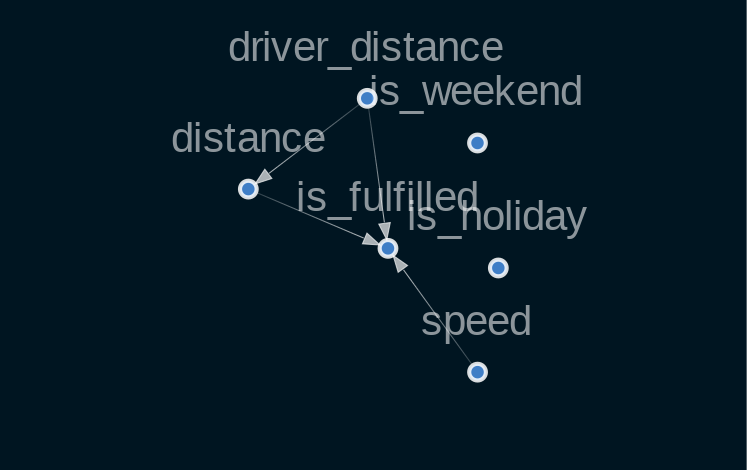

In [52]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [53]:
sm.add_edge("is_weekend", "is_fulfilled")
sm.add_edge("is_holiday", "is_fulfilled")

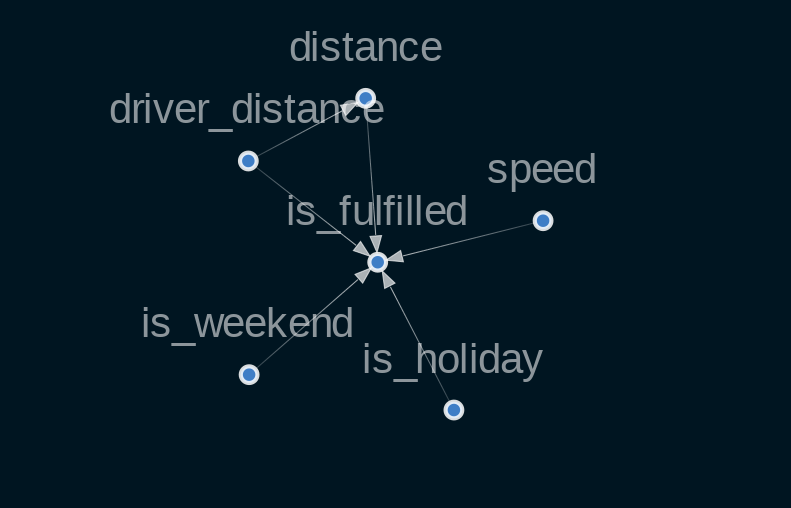

In [54]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

### Fitting the Conditional Distribution of the Bayesian Network

In [69]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

Preparing the Discretised Data
Cardinality of Categorical Features

In [56]:
df_c = preprocessed_trip_df_with_drivers.copy()
df_c

,is_weekend,is_holiday,distance,speed,driver_distance,is_fulfilled
4,0,0,20.984319,348.126952,0.694264,1
5,0,0,8.127195,14.237422,1.959786,1
6,0,0,5.040921,4.929996,2.947683,1
7,0,0,5.609962,9.607927,1.197389,1
8,0,0,19.082399,25.854963,0.197853,1
...,...,...,...,...,...,...
44825,0,0,2.582307,3.661404,1.633417,1
44847,1,0,3.590521,22.209406,2.736381,1
46712,1,0,26.751642,33.661626,3.094992,1
51071,0,0,18.333328,16.450643,1.842496,1


In [57]:
df_c['is_weekend'] = df_c['is_weekend'].apply(lambda x: 'weekday' if x == 0 else "weekend")
df_c['is_holiday'] = df_c['is_holiday'].apply(lambda x: 'holiday' if x !=0 else "no-holiday")
df_c['is_fulfilled'] = df_c['is_fulfilled'].apply(lambda x: 'fulfilled' if x !=0 else "unfulfilled")
df_c

,is_weekend,is_holiday,distance,speed,driver_distance,is_fulfilled
4,weekday,no-holiday,20.984319,348.126952,0.694264,fulfilled
5,weekday,no-holiday,8.127195,14.237422,1.959786,fulfilled
6,weekday,no-holiday,5.040921,4.929996,2.947683,fulfilled
7,weekday,no-holiday,5.609962,9.607927,1.197389,fulfilled
8,weekday,no-holiday,19.082399,25.854963,0.197853,fulfilled
...,...,...,...,...,...,...
44825,weekday,no-holiday,2.582307,3.661404,1.633417,fulfilled
44847,weekend,no-holiday,3.590521,22.209406,2.736381,fulfilled
46712,weekend,no-holiday,26.751642,33.661626,3.094992,fulfilled
51071,weekday,no-holiday,18.333328,16.450643,1.842496,fulfilled


### Discretising Numeric Features

To make numeric features categorical, they must first be discretised.

In [58]:
from causalnex.discretiser import Discretiser

In [59]:
discretised_data = df_c.copy()

In [60]:
discretised_data["distance"] = Discretiser(method="fixed",
        numeric_split_points=[1,100]).transform(discretised_data["distance"].values)
discretised_data["distance"].value_counts()

1    26039
0      390
2        7
Name: distance, dtype: int64

In [61]:
discretised_data["driver_distance"] = Discretiser(method="fixed",
        numeric_split_points=[1,100]).transform(discretised_data["driver_distance"].values)
discretised_data["driver_distance"].value_counts()

1    17361
0     9073
2        2
Name: driver_distance, dtype: int64

### Create Labels for Numeric Features

To make the discretised categories more readable, we can map the category labels onto something more meaningful in the same way that we mapped category feature values.

In [62]:
distance_map = {
    0: "short-distance",
    1: "medium-distance",
    2: "long-distance"
}
speed_map = {
    0: "slow-speed",
    1: "medium-speed",
    2: "fast-speed"
}

In [63]:
discretised_data["distance"] = discretised_data["distance"].map(distance_map)
discretised_data["driver_distance"] = discretised_data["driver_distance"].map(distance_map)
discretised_data["speed"] = discretised_data["speed"].map(speed_map)

In [64]:
discretised_data

,is_weekend,is_holiday,distance,speed,driver_distance,is_fulfilled
4,weekday,no-holiday,medium-distance,NaN,short-distance,fulfilled
5,weekday,no-holiday,medium-distance,NaN,medium-distance,fulfilled
6,weekday,no-holiday,medium-distance,NaN,medium-distance,fulfilled
7,weekday,no-holiday,medium-distance,NaN,medium-distance,fulfilled
8,weekday,no-holiday,medium-distance,NaN,short-distance,fulfilled
...,...,...,...,...,...,...
44825,weekday,no-holiday,medium-distance,NaN,medium-distance,fulfilled
44847,weekend,no-holiday,medium-distance,NaN,medium-distance,fulfilled
46712,weekend,no-holiday,medium-distance,NaN,medium-distance,fulfilled
51071,weekday,no-holiday,medium-distance,NaN,medium-distance,fulfilled


#### Train / Test Split

Like many other machine learning models, we will use a train and test split to help us validate our findings.

In [65]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

### Model Probability

With the learnt structure model from earlier and the discretised data, we can now fit the probability distrbution of the Bayesian Network. The first step in this is specifying all of the states that each node can take. This can be done either from data, or providing a dictionary of node values. We use the full dataset here to avoid cases where states in our test set do not exist in the training set. For real-world applications, these states may need to be provided using the dictionary method.

### Fit Conditional Probability Distributions

The fit_cpds method of BayesianNetwork accepts a dataset to learn the conditional probablilty distributions (CPDs) of each node, along with a method of how to do this fit.

In [ ]:
bn.cpds["is_fulfilled"]

#### Predict the State given the Input Data

The predict method of BayesianNetwork allows us to make predictions based on the data using the learnt Bayesian Network. For example, we want to predict if a trip is fulfilled or not based on the input data. Imagine we have a trip data that looks like this:

In [72]:
discretised_data.loc[57, discretised_data.columns != 'is_fulfilled']

is_weekend                 weekday
is_holiday              no-holiday
distance           medium-distance
speed                          NaN
driver_distance    medium-distance
Name: 57, dtype: object

In [ ]:
predictions = bn.predict(discretised_data, "is_fulfilled")

In [ ]:
print(f"The prediction is '{predictions.loc[57, 'is_fulfilled_prediction']}'")

### Modeling

#### Random Forest

In [75]:
preprocessed_trip_df_with_drivers

,is_weekend,is_holiday,distance,speed,driver_distance,is_fulfilled
4,0,0,20.984319,348.126952,0.694264,1
5,0,0,8.127195,14.237422,1.959786,1
6,0,0,5.040921,4.929996,2.947683,1
7,0,0,5.609962,9.607927,1.197389,1
8,0,0,19.082399,25.854963,0.197853,1
...,...,...,...,...,...,...
44825,0,0,2.582307,3.661404,1.633417,1
44847,1,0,3.590521,22.209406,2.736381,1
46712,1,0,26.751642,33.661626,3.094992,1
51071,0,0,18.333328,16.450643,1.842496,1


In [76]:
norm_df = preprocessed_trip_df_with_drivers.copy()
x = norm_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df

,0,1,2,3,4,5
0,0.0,0.0,0.030832,0.018849,0.004094,1.0
1,0.0,0.0,0.011927,0.000770,0.006017,1.0
2,0.0,0.0,0.007388,0.000266,0.007518,1.0
3,0.0,0.0,0.008225,0.000519,0.004859,1.0
4,0.0,0.0,0.028036,0.001399,0.003340,1.0
...,...,...,...,...,...,...
26431,0.0,0.0,0.003773,0.000197,0.005521,1.0
26432,1.0,0.0,0.005256,0.001202,0.007197,1.0
26433,1.0,0.0,0.039313,0.001822,0.007742,1.0
26434,0.0,0.0,0.026934,0.000890,0.005839,1.0
